In [1]:
import sys
sys.path.append("/Users/sigur.de.vries/Library/Mobile Documents/com~apple~CloudDocs/phd/MultiTreeGP")

import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10'

import jax
import jax.numpy as jnp
import diffrax
import jax.random as jr
import matplotlib.pyplot as plt

import MultiTreeGP.evaluators.dynamic_evaluate as dynamic_evaluate
from MultiTreeGP.genetic_programming import GeneticProgramming
from MultiTreeGP.environments.control_environments.acrobot import Acrobot

key = jr.PRNGKey(1)

These device(s) are detected:  [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


# Generate data

In [2]:
def get_data(key, env, batch_size, dt, T, param_setting):
    init_key, noise_key1, noise_key2, param_key = jr.split(key, 4)
    x0, targets = env.sample_init_states(batch_size, init_key)
    process_noise_keys = jr.split(noise_key1, batch_size)
    obs_noise_keys = jr.split(noise_key2, batch_size)
    ts = jnp.arange(0, T, dt)

    params = env.sample_params(batch_size, param_setting, ts, param_key)
    return x0, ts, targets, process_noise_keys, obs_noise_keys, params

init_key, data_key = jr.split(key)
batch_size = 16
T = 50
dt = 0.2
process_noise = 0.05
obs_noise = 0.1
param_setting = "Constant"

env = Acrobot(process_noise, obs_noise)

data = get_data(data_key, env, batch_size, dt, T, param_setting)

# Dynamic Symbolic Policy Learning

In [3]:
#Define hyperparameters
population_size = 100
num_populations = 5
num_generations = 50
state_size = 2

#Define expressions
operator_list = [("+", lambda x, y: x + y, 2, 0.5), 
                ("-", lambda x, y: x - y, 2, 0.1),
                ("*", lambda x, y: x * y, 2, 0.5),
                ("sin", lambda x: jnp.sin(x), 1, 0.1),
                ("cos", lambda x: jnp.cos(x), 1, 0.1)]

variable_list = [["y1", "y2", "y3", "y4", "a1", "a2", "u"], ["a1", "a2"]]

layer_sizes = jnp.array([state_size, env.n_control])

#Define evaluator
fitness_function = dynamic_evaluate.Evaluator(env, state_size, 0.05, solver=diffrax.Dopri5(), stepsize_controller=diffrax.PIDController(atol=1e-4, rtol=1e-4, dtmin=0.001), max_steps=1000)

In [4]:
#Initialize strategy
strategy = GeneticProgramming(num_generations, population_size, fitness_function, operator_list, variable_list, layer_sizes, num_populations = num_populations)

#Initialize population
population = strategy.initialize_population(init_key)

for g in range(num_generations):
    fitness, population = strategy.evaluate_population(population, data)
    
    if (g+1)%5==0:
        best_fitness, best_solution = strategy.get_statistics(g)
        
        print(f"In generation {g+1}, best fitness = {best_fitness:.4f}, best solution = {strategy.to_string(best_solution)}")

    if g < (num_generations-1):
        key, sample_key = jr.split(key)
        population = strategy.evolve(population, fitness, sample_key)

best_fitnesses, best_solutions = strategy.get_statistics()

Input data should be formatted as: ['y1', 'y2', 'y3', 'y4', 'a1', 'a2', 'u'].
In generation 5, best fitness = 171.8213, best solution = [-0.285*y1, 0.913088940312308*u + 0.913088940312308*y3], [-0.95*a1 - 4.15*a2]
In generation 10, best fitness = 150.3554, best solution = [0.95*sin(-a1 + y1 + 1.24), 0.999067025109795*u + 0.999067025109795*y3], [a1 - 4.15*a2 - cos(0.95*a1) - 0.8]
In generation 15, best fitness = 146.3892, best solution = [cos(u), 0.913088940312308*u + 0.913088940312308*y3], [-2.05*(a1 - 0.34)*(a2 + 0.9025)]
In generation 20, best fitness = 145.1357, best solution = [0.95*sin(y1 + sin(sin(u + 0.27)) - 1.62)*cos(a1), 0.913088940312308*u + 0.913088940312308*y3], [-6.2*a2 - 1.6325]
In generation 25, best fitness = 138.9638, best solution = [sin(y4)*sin(y1 - sin(y4)*sin(-a1 + y1 + 1.24) + 1.24), (u + y3)*cos(0.27*u + 0.27*y3)], [a1*a2 + 2*a1 - 4.15*a2 - cos(a2 + cos(0.95*a1)) - 1.23]
In generation 30, best fitness = 133.5592, best solution = [(-a1 - sin(y4)*sin(y1 + 1.24) + 

# Visualize best solution

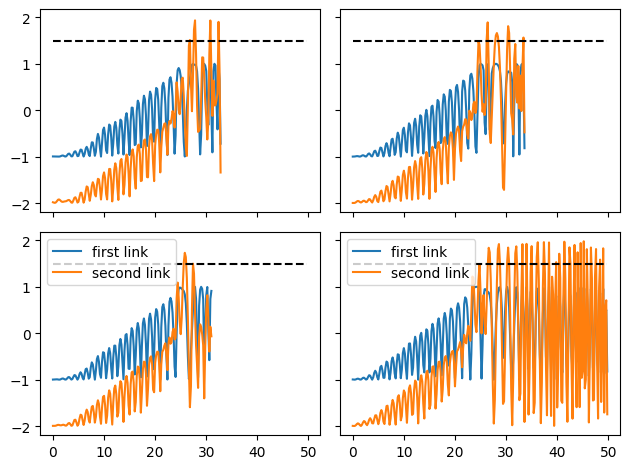

In [5]:
#Generate test_data
data = get_data(jr.PRNGKey(42), env, 4, dt, T, param_setting)
x0s, ts, targets, _, _, params = data

xs, ys, us, activities, fitness = fitness_function.evaluate_candidate(population[0,4], data, strategy.vmap_foriloop)

figure, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.ravel()

for i in range(4):
    ax[i].plot(ts, -jnp.cos(xs[i,:,0]), color = f"C{0}", label="first link")
    ax[i].plot(ts, -jnp.cos(xs[i,:,0]) - jnp.cos(xs[i,:,0] + xs[i,:,1]), color = f"C{1}", label="second link")
    ax[i].hlines(1.5, ts[0], ts[-1], linestyles='dashed', color = "black")

ax[-1].legend(loc="best")
ax[-2].legend(loc="best")
plt.tight_layout()
plt.show()